# DeepNeuralNetwork(Pytorch)

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import h5py
import sys

### 1Load Data

In [2]:
def load_data():
    '''
    create train set and test set
    make sure you have .h5 file in your dataset
    
    Returns:
    -------
        train_set_x_orig: original train set shape is (209, 64, 64, 3) 
        train_set_y_orig: original train label shape is (209,)
        test_set_x_orig: original test set shape is (50, 64, 64, 3)
        test_set_y_orig: original test label shape is (50,)
        classes: cat or non-cat.
        
    Note:
    ----
        (209, 64, 64, 3): 209 picture,64 width,64 height,3 channel.
    '''
    train_dataset = h5py.File('../data_set/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../data_set/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

### 2 Reshape Data

In [4]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1).T / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1).T / 255
train_y = train_y.reshape(-1,1).T
test_y = test_y.reshape(-1,1).T
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(12288, 209)
Test_x's shape:(12288, 50)
Train_y's shape:(1, 209)
Test_y's shape:(1, 50)


### 3 Create Pytorch of DNN

#### 3.1 create torch Variable

将Numpy类型的数据转换为Tensor.

```python
Variable(torch.Tensor(...))```



In [5]:
X_train = Variable(torch.Tensor(train_x))
y_train = Variable(torch.Tensor(train_y))
X_test = Variable(torch.Tensor(test_x))
y_test = Variable(torch.Tensor(test_y))

#### 3.2 create class and forward

在这里构建Model的时候,我们就不能使用简单的```torch.nn.Learn()```来快速计算线性值,因为我们的初始化需要使用```xavier initial```.

那么在torch中,我们可以:

$W:$

(1) ```torch.empty((units,inputs))```创建一个空的形状为(units,inputs)的tensor

(2) 使用```torch.nn.init.xavier_normal_```来初始化weights.

$b:$

bias的部分没有多大变化使用```torch.zeros(((units,1)))```来创建形状为(units,1)的tensor

(3) 创建Forward部分没有任何变化.

**Ps:**

(1) 需要注意在连续创建$W,b$的时候,我们需要将其放入$Parameter$中,可以使用ParameterDict,当然也可以使用其他形式保存参数,以便于后面backward时候更新参数.否则在进行optimizer的时候会报出model.parameters()为空的错误.

(2) 其他形式[参见](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20parameterdict#torch.nn.ParameterDict)

(3) 当然也可以完全像Lr(Pytorch)中一样完全自定义.

In [6]:
class DNN_torch(torch.nn.Module):
    """
    create torch of DNN
    
    Parameters:
    ----------
        layers: Model layers layers:input+layers.
        X: training data.
    """
    def __init__(self,layers,X):
        torch.nn.Module.__init__(self)
        torch.manual_seed(1)
        self.X = X
        n,m = X.shape
        layers.insert(0,n) # insert inputs layer
        self.L = len(layers)
        self.parameters_ = torch.nn.ParameterDict()
        for l in range(1,self.L):
            W = torch.nn.init.xavier_normal_(torch.empty(layers[l],layers[l-1]))
            b = torch.zeros((layers[l],1),requires_grad=True)
            self.parameters_['W'+str(l)] = torch.nn.Parameter(W)
            self.parameters_['b'+str(l)] = torch.nn.Parameter(b)
        
  
    def forward(self):
        """
        Implementation forward propagation.
        
        Return:
        ------
            A: the last layer sigmoid value.
        """
        A = self.X
        for l in range(1,self.L):
            W = self.parameters_['W'+str(l)]
            b = self.parameters_['b'+str(l)]
            Z = torch.add(torch.matmul(W,A),b)
            if l == self.L-1:
                A = torch.sigmoid(Z)
            else:
                A = torch.relu(Z)
        return A

#### 3.3 create accuracy function

创建一个在模型训练中求正确率的函数

(1) ```python torch.eq``` 挨个将元素进行对比,相同为True,否则为False.

(2) ```item()``` 取出float类型数值.

**Ps:**

```python torch.equal()``` 为整体进行比较相当于```all()```

In [7]:
def accuracy(A,y):
    """
    Compute correct rate.
    
    """
    m = y.shape[1]
    acc = torch.eq(torch.round(A),y).sum().item() / m
    return acc

#### 3.4 Create Model

创建Torch模型

(1) 初始化模型

```python
model = DNN_torch(layers,X)```

(2) 计算Loss

```python
Loss = torch.nn.BCELoss()```

(3) 创建优化器并更新参数,由于我们在class中已经保存了Parameters,所以这里的```model.parameters()```能够获取到.

```python
optimizer = torch.optim.SGD(params=model.parameters(),lr=alpha)```

(4) Start Training

(5) 重置梯度值:

Pytorch在梯度计算方面是使用累加的方式

```python
optimizer.zero_grad()```

(6) backward

```python
loss.backward()```

(7) 更新参数

```python
optimizer.step()```

In [8]:
def DNN_Model(X,y,layers,alpha,Iter,is_print=False):
    """
    Using Pytorch to build DNN
    
    Parameters:
    ----------
        X: data set.
        y: true labels.
        layers: model layers.
        alpha: learning rate.
        Iter: #Iteration.
        is_print: print loss if True.
    Returns:
    ------
        model.parameters_: the best weights and bias.
        model.L: #hidden layers.
    """
    m,n = X.shape
    
    model = DNN_torch(layers,X)
    
    Loss = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(params=model.parameters(),lr=alpha)
    costs = []
    accs = []
    for iter_ in range(Iter):
        A = model.forward()
        acc = accuracy(A,y)
        loss = Loss(A,y)
        if iter_ % 1000 == 0 and is_print:
            print('After iteration {} loss:{},acc:{} '.format(iter_,loss,acc))
            
        if iter_ % 100 == 0:
            costs.append(loss)
            accs.append(acc)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # plot loss and accuracy
    plt.plot(costs,c='orange',label='loss')
    plt.plot(accs,c='green',label='accuracy')
    plt.title('Lr:{}'.format(alpha))
    plt.xlabel('Iteration')
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    return model.parameters_,model.L

After iteration 0 loss:0.7010855674743652,acc:0.3588516746411483 
After iteration 1000 loss:0.09601536393165588,acc:0.9808612440191388 


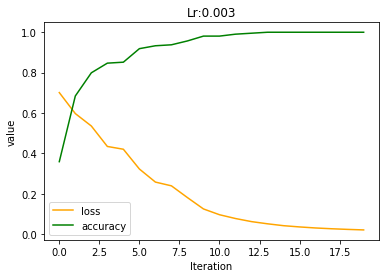

In [9]:
parameters_,L = DNN_Model(X_train,y_train,[20,7,5,1],0.003,2000,True)

### 4 Score

将样本进行评分

In [10]:
def score(X,y,parameters,L):
    """
    Score Model
    Parameters:
    ----------
        X: data set.
        y: true labels.
        parameters: best weights and bias.
        L: #model layers.
    Return:
    ------
        acc: accuracy.
    """
    A = X
    m = y.shape[1]
    
    for l in range(1,L):
        W = parameters['W'+str(l)]
        b = parameters['b'+str(l)]
        Z = torch.add(torch.matmul(W,A),b)
        if l == L-1:
            A = torch.sigmoid(Z)
        else:
            A = torch.relu(Z)
            
    acc = torch.eq(torch.round(A),y).sum().item() / m
    return acc

In [11]:
acc = score(X_test,y_test,parameters_,L)
print('The test acc is {}'.format(acc))

The test acc is 0.76


这里就不再测试另外的图片了,如果想测试自己的图片可以按照Application或者Tensorflow中的方法测试.

# Summary

这里使用Pytorch操作会出现过拟合的现象,当然可能存在的问题是训练样本量太小,可以适当的多增加一些数据,还可以将每张图片进行左右翻转,这样的话在某些情况下会使得效果有所改善.

实际上解决过拟合最好的方法时增加数据集,当然后面我们也会有一些办法来处理过拟合的一些问题.